In [1]:
# General libraries:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Personal libraries:
from robin_helperfunctions import round_to_hour
from robinhoodstrategy import cryptoStrategy, BackcastStrategy, Trade

# Deep learning libraries:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [2]:
# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')

# Pull just the value fields:
df = df[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']]

# Load just ~2018 onwards:
# df = df[2500:]

df.head()

,price_close,price_open,price_high,price_low,volume_traded,trades_count
0,11.8895,11.87000,11.90000,11.85972,1076.171006,48
1,12.0000,11.89000,12.00000,11.89000,6184.443260,182
2,12.0300,12.00000,12.03000,11.93356,3391.487460,120
3,12.2000,12.02591,12.20000,12.00000,1590.240506,53
4,12.4310,12.20000,12.54799,12.20000,4801.330298,164


In [22]:
df.head(24)

,price_close,price_open,price_high,price_low,volume_traded,trades_count,pctchange,entry_flag
0,11.88950,11.87000,11.90000,11.85972,1076.171006,48,NaN,1.0
1,12.00000,11.89000,12.00000,11.89000,6184.443260,182,NaN,1.0
2,12.03000,12.00000,12.03000,11.93356,3391.487460,120,NaN,0.0
3,12.20000,12.02591,12.20000,12.00000,1590.240506,53,NaN,0.0
4,12.43100,12.20000,12.54799,12.20000,4801.330298,164,NaN,0.0
5,12.53369,12.39040,12.59809,12.31003,3566.448442,92,0.054181,0.0
6,12.73950,12.53369,12.89950,12.48000,7815.423254,199,0.061625,0.0
7,12.59420,12.65747,12.79000,12.51000,2760.369206,65,0.046899,0.0
8,12.48257,12.59239,12.59840,12.44000,2267.837906,57,0.023161,0.0
9,12.46280,12.61000,12.61438,12.44005,3034.616506,87,0.002558,0.0


In [3]:
def entry_flag(df, lookforward_num=5, pct_gain=0.05):
    
    '''If there will be over a 5% gain in the next 6 periods, flag as a 1. Else 0.'''
    
    df['pctchange'] = df[['price_close']].pct_change(lookforward_num)
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['pctchange'] >= pct_gain:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [4]:
df['entry_flag'] = entry_flag(df)
df['entry_flag'].value_counts()

0.0    7372
1.0    1036
Name: entry_flag, dtype: int64

In [5]:
def create_sequence(df, n_input): 
    
    data = np.array(df)
    
    X = list()
    start = n_input
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input*2].values).reshape(-1,1)

In [6]:
seq_len = 24
df_features = df.drop(columns=['pctchange', 'entry_flag'])
X = create_sequence(df_features, seq_len)
y = create_targets(df, seq_len)

In [7]:
def normalized_df(X):
    return np.array([x/x[0]-1 for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [8]:
X_norm = normalized_df(X)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6673, 24, 6) (6673, 1)
(1669, 24, 6) (1669, 1)


In [9]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [10]:
# define the CNN model
model = Sequential()
model.add(Conv1D(32, 8, activation='relu', input_shape=(n_timesteps,n_features))) 
# model.add(Conv1D(32, 8, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

0.9736369252204895


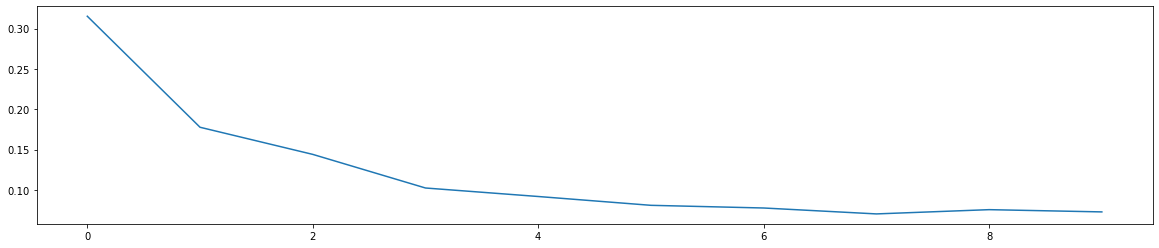

In [11]:
verbose, epochs, batch_size = 0, 10, 32
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
plt.figure(figsize=(20,4))
print(accuracy)
plt.plot(results.history['loss'])
plt.show()

In [17]:
predictions = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1541
1     128
dtype: int64

In [21]:
df_plot

,price_close,price_open,price_high,price_low,volume_traded,trades_count,pctchange,entry_flag,predictions
6744,149.33,145.81,153.12,145.70,15456.161574,1930,0.008714,0.0,0
6745,149.92,149.31,149.94,149.28,1115.448185,403,0.017303,0.0,0
6746,145.30,149.90,150.15,144.45,15308.970973,1808,0.003730,0.0,0
6747,144.92,145.29,145.94,143.91,3102.488222,579,0.005272,0.0,1
6748,145.69,144.91,146.43,143.94,6010.843128,803,-0.000549,0.0,1
...,...,...,...,...,...,...,...,...,...
8408,352.51,353.48,359.90,348.35,18060.435159,4312,0.073220,NaN,1
8409,348.30,352.50,358.50,344.10,11786.213649,2541,0.022487,NaN,1
8410,343.44,347.95,351.55,337.26,14951.134623,2988,-0.031008,NaN,0
8411,335.77,343.46,349.46,332.31,18696.797778,3650,-0.025794,NaN,0


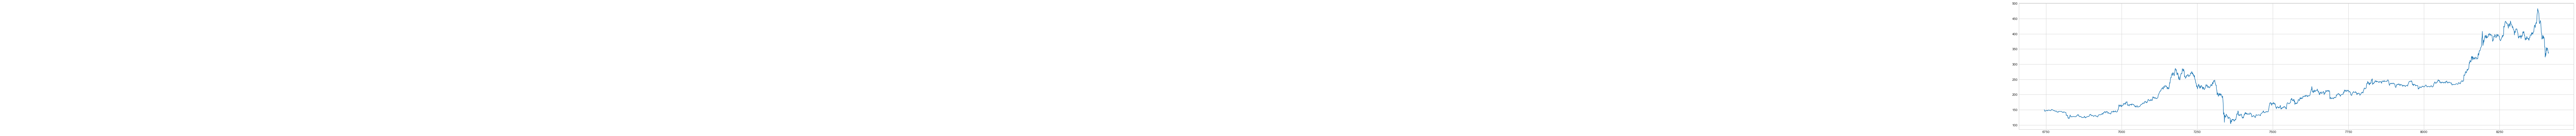

In [20]:
df_plot = df[-len(X_test):]
df_plot['predictions'] = predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,7))

df_plot['price_close'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 8] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig('result_plot.png')

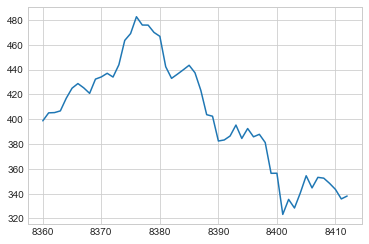

In [54]:
df_plot.loc[8360:]['price_close'].plot()

In [48]:
df_plot[df_plot['entry_flag']==1]

,price_close,price_open,price_high,price_low,volume_traded,trades_count,pctchange,entry_flag,predictions
6824,121.75,122.64,123.10,119.62,24784.506558,2651,-0.076112,1.0,0
6825,123.73,121.75,125.44,121.32,13743.108024,1256,-0.054052,1.0,0
6826,121.69,123.72,124.38,120.74,24605.075843,7289,-0.077687,1.0,0
6890,127.83,128.70,128.99,127.76,2837.924210,373,0.007091,1.0,0
6891,127.84,127.82,127.93,127.37,1300.367116,274,0.006931,1.0,0
...,...,...,...,...,...,...,...,...,...
8372,433.98,436.81,438.51,428.66,13476.368398,3166,0.020553,1.0,1
8373,443.88,434.00,444.41,428.68,14025.545545,3049,0.054773,1.0,0
8401,323.29,357.08,359.43,311.04,99870.049276,14288,-0.162070,1.0,0
8402,335.38,323.43,337.55,314.83,36026.491585,5561,-0.135240,1.0,0


In [39]:
print(classification_report(df_plot['entry_flag'][10:-10].values, df_plot['predictions'][10:-10].values))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89      1500
         1.0       0.06      0.07      0.06       149

    accuracy                           0.80      1649
   macro avg       0.48      0.48      0.48      1649
weighted avg       0.83      0.80      0.82      1649



In [40]:
confusion_matrix(df_plot['entry_flag'][10:-10].values, df_plot['predictions'][10:-10].values)

array([[1315,  185],
       [ 138,   11]])

model.save('4hr_6period_cnn.h5')

___

In [19]:
current_data = np.array(df.tail(12)[['price_close', 'price_open', 'price_high', 'price_low', 'volume_traded', 'trades_count']])

In [21]:
current_data

array([[  323.29      ,   357.08      ,   359.43      ,   311.04      ,
        99870.04927612, 14288.        ],
       [  335.38      ,   323.43      ,   337.55      ,   314.83      ,
        36026.49158499,  5561.        ],
       [  328.46      ,   334.88      ,   343.68      ,   322.59      ,
        19048.94287827,  3498.        ],
       [  340.64      ,   328.03      ,   342.49      ,   316.6       ,
        29873.54119927,  4128.        ],
       [  354.43      ,   340.22      ,   355.66      ,   337.38      ,
        21597.71039302,  3942.        ],
       [  344.66      ,   354.41      ,   358.28      ,   337.5       ,
        17078.22764453,  3658.        ],
       [  353.15      ,   344.41      ,   355.41      ,   340.8       ,
        18222.60354605,  3422.        ],
       [  352.51      ,   353.48      ,   359.9       ,   348.35      ,
        18060.43515883,  4312.        ],
       [  348.3       ,   352.5       ,   358.5       ,   344.1       ,
        11786.21364931, 